# Biostat M280 Homework 3

**Due Friday, May 25 @ 11:59PM**

## Q1 - Big $n$ regression

Those who took my _203B: Introduction to Data Science_ last quarter had a (painful) experience of wrangling an Apache Spark cluster to do linear regression on a dataset with more than 100 million observations. Now we learnt various methods for solving linear regression and should realize that, with right choice of algorithm, it is a problem that can be handled by any moderate computer.

### Q1(1)

Download the flight data from <http://stat-computing.org/dataexpo/2009/the-data.html>. For this exercise, we only need data from years 2003-2008. If you are using Mac or Linux, you can run the following Bash script, which downloads and unzips files for all years.
```bash
# Download flight data by year
for i in {1987..2008}
  do
    echo "$(date) $i Download"
    fnam=$i.csv.bz2
    wget -O ./$fnam http://stat-computing.org/dataexpo/2009/$fnam
    echo "$(date) $i unzip"
    bzip2 -d ./$fnam
  done

# Download airline carrier data
wget -O ./airlines.csv http://www.transtats.bts.gov/Download_Lookup.asp?Lookup=L_UNIQUE_CARRIERS

# Download airports data
wget -O ./airports.csv https://raw.githubusercontent.com/jpatokal/openflights/master/data/airports.dat
```
Find out how many data points in each year.

### Answer to Q1(1)  

I used countlines to get the number of data points in each year (2003-2008).

In [1]:
# how many data points
println(countlines("2003.csv"))
println(countlines("2004.csv"))
println(countlines("2005.csv"))
println(countlines("2006.csv"))
println(countlines("2007.csv"))
println(countlines("2008.csv"))

6488541
7129271
7140597
7141923
7453216
7009729


### Q1(2) 

We are interested in how the time gain of a flight, defined as `DepDelay - ArrDelay`, depends on the distance traveled (`Distance`), departure delay (`DepDelay`), and carrier (`UniqueCarrier`). 

We want to fit a linear regression `Gain ~ 1 + Distance + DepDelay + UniqueCarrier` using data from 2003-2008. Note `UniqueCarrier` is a factor with 23 levels: "9E", "AA", "AQ", "AS", "B6", "CO", "DH", "DL", "EV", "F9", "FL", "HA", "HP", "MQ", "NW", "OH", "OO", "TZ", "UA", "US", "WN", "XE", and "YV". We use the dummy coding with "9E" as base level.

Will the design matrix (in double precision) fit into the memory of you computer?

### Answer to Q1(2)  

If we use double precision for the design matrix and use '9E' and basd level, there will be `(22+4)` columns for 2003-2008. From the Q1(1), we have alreday known that there are `(6488541+7129271+7140597+7141923+7453216+7009729) = 42363277` observations in year 2003-2008. So the design matrix could take up about `42363277 * 26 * 8 bytes = 8.8 Gb` in memory, which can not be fitted into the memory of my laptop (8Gb memory).   

The following show an example to load data in 2003 into memory. 

In [2]:
# Pkg.add("JuliaDB")
# import data from csv
using JuliaDB

In [3]:
@time yrtable = loadtable(
    "2003.csv", 
    datacols = ["DepDelay", "ArrDelay", "UniqueCarrier", "Distance"])

 57.839464 seconds (153.25 M allocations: 8.148 GiB, 24.30% gc time)


Table with 6488540 rows, 4 columns:
DepDelay  ArrDelay  UniqueCarrier  Distance
───────────────────────────────────────────
-4        -1        "UA"           837
-1        -3        "UA"           837
29        23        "UA"           837
-2        -9        "UA"           1835
18        52        "UA"           1835
-4        6         "UA"           1835
-4        -8        "UA"           1835
0         2         "UA"           1835
-4        19        "UA"           1835
3         4         "UA"           413
-4        -23       "UA"           413
-3        -19       "UA"           413
⋮
#NA       #NA       "DL"           1891
29        62        "DL"           581
39        66        "DL"           1891
26        27        "DL"           1678
114       134       "DL"           946
44        53        "DL"           813
16        47        "DL"           432
50        54        "DL"           432
-3        -5        "DL"           453
3         3         "DL"           689
-1     

### Q1(3)

Review the [Summary of Linear Regression](http://hua-zhou.github.io/teaching/biostatm280-2018spring/slides/12-linreg/linreg.html) and devise a strategy to solve the linear regression.

Report the estimated regression coefficients $\widehat \beta$, estimated variance $\widehat \sigma^2 = \sum_i (y_i - \widehat y_i)^2 / (n - 1)$, and coefficient standard errors.

Hint: It took my laptop less than 3 minutes to import data and fit linear regression.

### Answer to Q1(3)  

Though the design matrix cannot be fitted into the memory, Cholesky and Sweep methods could solved linear regression models based on the Gram matrix $\mathbf{X}^{T}\mathbf{X}$ , which can be dynamically updated with incoming data. They can handle huge $n$ , moderate $p$ data sets that cannot fit into memory. Here, I used Sweep method to solve linear regression model, since it could give standard errors and so on.   

In order to make linear regression scalable for large scale datasets, I compute the Gram matrix $\mathbf{X}^{T}\mathbf{X}$ for each year data separately and sum them together to form the final Gram matrix.

In [4]:
# mapping from variable names to X columns
# carrier "9E" is used as base level
const var2col = Dict(
        "Intercept" => 1,
        "Distance" => 2,
        "DepDelay" => 3,
        "AA" => 4,
        "AQ" => 5,
        "AS" => 6,
        "B6" => 7,
        "CO" => 8,
        "DH" => 9,
        "DL" => 10,
        "EV" => 11,
        "F9" => 12,
        "FL" => 13,
        "HA" => 14,
        "HP" => 15,
        "MQ" => 16,
        "NW" => 17,
        "OH" => 18,
        "OO" => 19,
        "TZ" => 20,
        "UA" => 21,
        "US" => 22,
        "WN" => 23,
        "XE" => 24,
        "YV" => 25,
        "Gain" => 26)
# mapping from column to variable names
const col2var = map(reverse, var2col)
# a custom function to generate [X y] from data table
function generate_xy(tbl::NextTable)
    # X matrix
    XY = zeros(length(tbl), 26)
    # intercept term
    @views fill!(XY[:, 1], 1)
    # Distance term
    @views copy!(XY[:, 2], columns(tbl, :Distance))
    # DepDelay term
    @views copy!(XY[:, 3], columns(tbl, :DepDelay))
    # Dummy coding for airline
    @inbounds for i in 1:length(tbl)
        # yrtable[i][:UniqueCarrier] == "9E" && continue # base level
        tbl[i][:UniqueCarrier] == "9E" && continue # base level
        XY[i, var2col[tbl[i][:UniqueCarrier]]] = 1
    end
    # last column is response: gain = depdelay - arrdelay
    XY[:, 26] = select(tbl, 
        (:DepDelay, :ArrDelay) => p -> Float64(p.DepDelay - p.ArrDelay))
    # return
    XY
end

generate_xy (generic function with 1 method)

In [5]:
using SweepOperator

In [6]:
function fit_linear_function(p)
    n = 0
    Gram = zeros(p + 1, p + 1)
    for i = 2003: 2008
        yrtable = loadtable(string(i, ".csv"), datacols = ["DepDelay", "ArrDelay", "UniqueCarrier", "Distance"]);
        # drop rows with missing values
        yrtable = dropna(yrtable)
        xy = generate_xy(yrtable)
        n = n + size(xy, 1)
        Gram .= Gram + xy' * xy
        # println(i)
    end
    sweep!(Gram, 1:p)
    return n, Gram
end

fit_linear_function (generic function with 1 method)

In [7]:
@time n, Gram = fit_linear_function(25)

221.237451 seconds (484.57 M allocations: 44.809 GiB, 20.81% gc time)


(41490375, [-2.00254e-6 4.21792e-11 … 1.98347e-6 1.14033; 3.00028e10 -9.38376e-14 … -5.01596e-12 0.00164935; … ; 822290.0 3.27927e8 … -3.19909e-6 -0.202211; 6.0236e7 5.75882e10 … 1.18638e6 8.48076e9])

In [10]:
# estimated regression coefficients 
p = 25
σ2 = Gram[p + 1, end] / (n - 1)

204.4031074256946

In [11]:
# Compute the standart errors of coefficients
β_var = - Diagonal(Gram[1:p, 1:p] * σ2);
β_se = sqrt.(β_var)

25×25 SparseMatrixCSC{Float64,Int64} with 25 stored entries:
  [1 ,  1]  =  0.0202318
  [2 ,  2]  =  4.37958e-6
  [3 ,  3]  =  6.88878e-5
  [4 ,  4]  =  0.0215571
  [5 ,  5]  =  0.0521477
  [6 ,  6]  =  0.0250361
  [7 ,  7]  =  0.0259154
  [8 ,  8]  =  0.0229534
  [9 ,  9]  =  0.0266552
  [10, 10]  =  0.021659
  ⋮
  [15, 15]  =  0.0276918
  [16, 16]  =  0.0218055
  [17, 17]  =  0.0220088
  [18, 18]  =  0.023446
  [19, 19]  =  0.0217463
  [20, 20]  =  0.0375073
  [21, 21]  =  0.0219444
  [22, 22]  =  0.0220022
  [23, 23]  =  0.0209201
  [24, 24]  =  0.0222383
  [25, 25]  =  0.0255715

### Q1(4)

Go to your resume/cv and claim you have experience performing analytics on data with hundred millions of observations.

Updated.

## Q2 - Google PageRank

We are going to try different numerical methods learnt in class on the [Google PageRank problem](https://en.wikipedia.org/wiki/PageRank).

### Q2(1)

Let $\mathbf{A} \in \{0,1\}^{n \times n}$ be the connectivity matrix of $n$ web pages with entries
$$
\begin{eqnarray*}
	a_{ij}= \begin{cases}
	1 & \text{if page $i$ links to page $j$} \\
	0 & \text{otherwise}
	\end{cases}.
\end{eqnarray*}
$$
$r_i = \sum_j a_{ij}$ is the out-degree of page $i$. That is $r_i$ is the number of links on page $i$. Imagine a random surfer exploring the space of $n$ pages according to the following rules.  

- From a page $i$ with $r_i>0$
    * with probability $p$, (s)he randomly chooses a link on page $i$ (uniformly) and follows that link to the next page  
    * with probability $1-p$, (s)he randomly chooses one page from the set of all $n$ pages (uniformly) and proceeds to that page  
- From a page $i$ with $r_i=0$ (a dangling page), (s)he randomly chooses one page from the set of all $n$ pages (uniformly) and proceeds to that page  
    
The process defines a Markov chain on the space of $n$ pages. Write down the transition matrix $\mathbf{P}$ of the Markov chain as a sparse matrix plus rank-1 matrix.

### Answer to Q2(1)  


$
P_{ij}  = \begin{cases}
	\frac{1-p}{n} + {\frac{a_{ij}p}{r_{i}}} & \text{if $r_{i} \neq 0$} \\
	\frac{1}{n} & \text{otherwise}
	\end{cases}
$  

Write in terms of sparse matrix $\mathbf{Q}$ plus rank-1 matrix $\mathbf{R}$  

$
Q_{ij}  = \begin{cases}
	-\frac{p}{n} + {\frac{a_{ij}p}{r_{i}}} & \text{if $r_{i} \neq 0$} \\
	0 & \text{otherwise}
	\end{cases}
$   

$
R_{ij}  = \frac{1}{n}\mathbf{1}\mathbf{1}^{T}
$  

$
\mathbf{P} = \mathbf{Q} + \mathbf{R}
$


### Q2(2)

According to standard Markov chain theory, the (random) position of the surfer converges to the stationary distribution $\mathbf{x} = (x_1,\ldots,x_n)^T$ of the Markov chain. $x_i$ has the natural interpretation of the proportion of times the surfer visits page $i$ in the long run. Therefore $\mathbf{x}$ serves as page ranks: a higher $x_i$ means page $i$ is more visited. It is well-known that $\mathbf{x}$ is the left eigenvector corresponding to the top eigenvalue 1 of the transition matrix $\mathbf{P}$. That is $\mathbf{P}^T \mathbf{x} = \mathbf{x}$. Therefore $\mathbf{x}$ can be solved as an eigen-problem. Show that it can also be cast as solving a linear system. Since the row sums of $\mathbf{P}$ are 1, $\mathbf{P}$ is rank deficient. We can replace the first equation by the $\sum_{i=1}^n x_i = 1$.

### Answer to Q2(2)  


The problem of solving eigen-problem $\mathbf{P}^{T}\mathbf{x} = \mathbf{x}$ is equivalent to $(\mathbf{P}^T-\mathbf{I})\mathbf{x} = \mathbf{0}$ Since the row sums of $\mathbf{P}$ are 1, $\mathbf{P}$ is rank deficient, and we cannot use LU decomposition to solve it directly. In order to solve the problem, we can add another row to the original problem. 

$
\
\begin{bmatrix}
\mathbf{P_n}^{T} - \mathbf{I_n} \\
\mathbf{1}
\end{bmatrix}\mathbf{x}= 
\begin{bmatrix}
\mathbf{0_n}\\
\mathbf{1}
\end{bmatrix}
\
$  

So if we set $\mathbf{A} =
\begin{bmatrix}
\mathbf{P_n}^{T} - \mathbf{I_n} \\
\mathbf{1}
\end{bmatrix} $ and $\mathbf{b} = \begin{bmatrix}
\mathbf{0_n}\\
\mathbf{1}
\end{bmatrix}$, we can solve the linear system $\mathbf{A}\mathbf{x}=\mathbf{b}$

### Q2(3)

Download the [`ucla.zip`](http://hua-zhou.github.io/teaching/biostatm280-2018spring/hw/hw3/ucla.zip) package from course webpage. Unzip the package, which contains two files `U.txt` and `A.txt`. `U.txt` lists the 500 URL names. `A.txt` is the $500 \times 500$ connectivity matrix. Read data into Julia. Compute summary statistics:
* number of pages
* number of edges
* number of dangling nodes (pages with no out links)
* which page has max in-degree?
* which page has max out-degree?
* visualize the sparsity pattern of $\mathbf{A}$

### Answer to Q2(3)  


In [12]:
# Pkg.add("CSV")
using CSV

In [14]:
# Load the data into Julia
data_u_loc = "U.txt"
data_a_loc = "A.txt"
U = CSV.read(data_u_loc, header = 0);
A = Array(CSV.read(data_a_loc, header = 0));
# Get the number of pages, which corresponds to the number of lines in U
println("The number of pages is ", size(U, 1))
println("The number of edges is ", sum(A))

The number of pages is 500
The number of edges is 11158


In [15]:
# Get the number of dangling nodes
n_dangling = 0
for row = 1:500
    if sum(A[row, :]) == 0
        n_dangling = n_dangling + 1
    end
end
println("The number of dangling nodes is ", n_dangling)

The number of dangling nodes is 96


In [16]:
# Keep record for maximum in-degree
max_in = 0
# Keep record for the index of page with maximum in-degree
max_in_index = 0
# Keep record for maximum out-degree
max_out = 0
# Keep record for the index of page with maximum out-degree
max_out_index = 0
for idx = 1:500
    out_degree = sum(A[idx, :])
    if out_degree > max_out
        max_out = out_degree
        max_out_index = idx
    end
    
    in_degree = sum(A[:, idx])
    if in_degree > max_in
        max_in = in_degree
        max_in_index = idx
    end
    
end
println("The page with maximum out degree ", max_out_index)
println(U[max_out_index, :])
println("The page with maximum in degree ", max_in_index)
println(U[max_in_index, :])

The page with maximum out degree 36
1×1 DataFrames.DataFrame
│ Row │ Column1                │
├─────┼────────────────────────┤
│ 1   │ http://giveto.ucla.edu │
The page with maximum in degree 1
1×1 DataFrames.DataFrame
│ Row │ Column1             │
├─────┼─────────────────────┤
│ 1   │ http://www.ucla.edu │


In [17]:
using PyPlot

The following picture shows the sparsity pattern of $\mathbf{A}$, and we can see it's very sparse. 

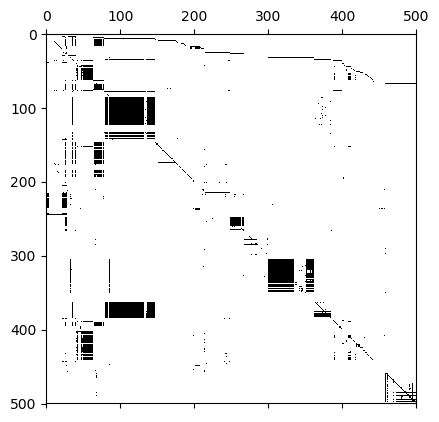

PyObject <matplotlib.image.AxesImage object at 0x1225e0690>

In [18]:
# Show the Sparsity pattern of A
spy(full(A))

### Q2(4)

Set the _teleportation_ parameter at $p = 0.85$. Try the following methods to solve for $\mathbf{x}$ using the `ucla.zip` data.

0. A dense linear system solver such as LU decomposition.  
0. A simple iterative linear system solver such as Jacobi or Gauss-Seidel.   
0. A dense eigen-solver.  
0. A simple iterative eigen-solver such as the power method.  

For iterative methods, you can use the [`IterativeSolvers.jl`](https://github.com/JuliaMath/IterativeSolvers.jl) package. Make sure to utilize the special structure of $\mathbf{P}$ (diagonal + rank 1) to speed up the matrix-vector multiplication.

### Answer to Q2(4)

In [19]:
# Pkg.add("IterativeSolvers")
using BenchmarkTools, IterativeSolvers

Use dense linear system solver (LU decomposition)  

Since $\mathbf{P}$ is rank deficient, we can add an additional row in order to use LU decomposition. 

In [21]:
# Construct P in terms of a sparse matrix plus a rank 1 matrix
P_sparse = zeros(size(A, 1), size(A, 2))
for idx = 1:500
    # compute all out degrees
    sum_out = sum(A[idx, :])
    if sum_out != 0
        for idy = 1: 500
            P_sparse[idx, idy] =  
                A[idx, idy] * 0.85 / sum_out - 0.85 / 500
        end
    end
end
P_sparse = sparse(P_sparse)
P_t = P_sparse' + (1 / 500) * ones(500, 500) - I
# Augment P with one row
P_aug = [P_t; ones(1, 500)]
# Similarly, augment b with one row
b = [zeros(500, 1); 1];

In [22]:
# Compute LU decomposition to solve linear function
@time P_lu = lufact(P_aug);
x = P_lu[:L] \ (sparse(P_lu[:P]) * b)
x_lu = P_lu[:U] \ x

  0.056282 seconds (6.42 k allocations: 2.261 MiB)


500×1 Array{Float64,2}:
 0.0115263 
 0.00118521
 0.00368196
 0.00361842
 0.00118521
 0.00118521
 0.00118521
 0.00118521
 0.00118521
 0.00118521
 0.00118521
 0.00137118
 0.00133263
 ⋮         
 0.00136037
 0.00136037
 0.00129072
 0.00337188
 0.00215239
 0.00136037
 0.00136037
 0.00750605
 0.00136037
 0.00136037
 0.00136037
 0.00107129

Use iterative linear solver (Jacobi).  

Here we don't need to augment $\mathbf{P}$ in order to solve the linear system.  

Since $\mathbf{P}$ can be written in terms of a sparse matrix and a rank-1 matrix, we can use this structure to accelerate the calculation. 

From the lecture notes, we can know with splitting the matrix $\mathbf{P}$ into $\mathbf{L} + \mathbf{U} + \mathbf{D}$ that the Jacobi can be written as  

$$
\mathbf{x^{(t+1)}} = -\mathbf{D}^{-1}\mathbf{P}\mathbf{x^{(t)}} + \mathbf{x^{(t)}} + \mathbf{D}^{-1}\mathbf{b}
$$  

Since $\mathbf{P}$ can be written in term of a sparse matrix $\mathbf{Q}$ plus a rank-1 matrix $\mathbf{R}$, and $\mathbf{b}$ is all-zeros, we can re-write the Jacobi iteration as following:  

$$
\mathbf{x^{(t+1)}} = -\mathbf{D}^{-1}(\mathbf{Q} + \frac{1}{n}\mathbf{1}\mathbf{1}^{T} - \mathbf{I})\mathbf{x^{(t)}} + \mathbf{x^{(t)}} + \mathbf{D}^{-1}\mathbf{b}
= -\mathbf{D}^{-1}\mathbf{Q}\mathbf{x^{(t)}} - \frac{1}{n}\mathbf{D}^{-1}\mathbf{1}\sum{\mathbf{x^{(t)}}}
$$ 

In [24]:
function sparse_jacobi(x, Q, D, b, tol, max_iter)
    i = 1
    diff = 100
    n = size(x, 1)
    e = ones(n, 1)
    Qx = rand(size(x, 1), size(x, 2))
    while diff > tol
        if i > max_iter
            return x
        end
        # inv(D) is cheap, since D is diagonal matrix
        x_next = - inv(D) * (At_mul_B!(Qx, Q, x) +  
            e * (1 / n) * sum(x) - x) + x
        diff = vecnorm((x_next - x))
        x = x_next
        i = i + 1
    end
    return x
end

sparse_jacobi (generic function with 1 method)

In [25]:
A = Array(CSV.read(data_a_loc, header=0));
rowsums = sum(A, 2)
p = 0.85
n = 500
Q = zeros(n, n)
for i = 1:500
    if rowsums[i] != 0
        for j = 1:500
            Q[i, j] = A[i, j] * (p / rowsums[i]) - p / n
        end
    end
end
# Use the sparsity, write P in terms of one sparse matrix and one rank-1
Q = sparse(Q);
# Q = Q' + 1/n - I
D = Diagonal(Q) + Diagonal(ones(500, 500) * 1 / n - 1);

In [26]:
typeof(D)
# inv(D) is cheap
@which inv(D)

inv(D::Diagonal{T}) where T in Base.LinAlg at linalg/diagonal.jl:322

In [27]:
x_init = rand(500, 1)
b = zeros(500, 1)
res = sparse_jacobi(x_init, Q, D, b, 1e-6, 400)
res = res / sum(res)

500×1 Array{Float64,2}:
 0.0115263 
 0.00118521
 0.00368196
 0.00361842
 0.00118521
 0.00118521
 0.00118521
 0.00118521
 0.00118521
 0.00118521
 0.00118521
 0.00137118
 0.00133263
 ⋮         
 0.00136037
 0.00136037
 0.00129072
 0.00337188
 0.00215239
 0.00136037
 0.00136037
 0.00750605
 0.00136037
 0.00136037
 0.00136037
 0.00107129

Use dense eigen algorithm.   

$\mathbf{x}$ is the left eigenvector corresponding to the top eigenvalue 1 of the transition matrix $\mathbf{P}$. Then we get the real part of eigen decomposition and normalize it to get $\mathbf{x}$

In [34]:
# Construct P in terms of a sparse matrix plus a rank 1 matrix
P_sparse = zeros(size(A, 1), size(A, 2))
for idx = 1:500
    # compute all out degrees
    sum_out = sum(A[idx, :])
    if sum_out != 0
        for idy = 1: 500
            P_sparse[idx, idy] =  
                A[idx, idy] * 0.85 / sum_out - 0.85 / 500
        end
    end
end
P_sparse = sparse(P_sparse)

500×500 SparseMatrixCSC{Float64,Int64} with 202000 stored entries:
  [1  ,   1]  =  -0.0017
  [2  ,   1]  =  -0.0017
  [5  ,   1]  =  -0.0017
  [6  ,   1]  =  -0.0017
  [7  ,   1]  =  0.0369364
  [8  ,   1]  =  0.0104429
  [9  ,   1]  =  0.0369364
  [10 ,   1]  =  0.0369364
  [11 ,   1]  =  0.0171889
  [12 ,   1]  =  0.0369364
  ⋮
  [489, 500]  =  -0.0017
  [490, 500]  =  0.0257194
  [491, 500]  =  -0.0017
  [492, 500]  =  -0.0017
  [493, 500]  =  -0.0017
  [494, 500]  =  -0.0017
  [495, 500]  =  -0.0017
  [496, 500]  =  0.0266333
  [497, 500]  =  -0.0017
  [498, 500]  =  0.0266333
  [499, 500]  =  -0.0017

In [35]:
P_sparse_eigen = P_sparse' + (1 / 500) * ones(500, 500);

In [36]:
P_eigen = eigfact(P_sparse_eigen)[:vectors][:, 1]
x_eigen = real.(P_eigen) / sum(real.(P_eigen))

500-element Array{Float64,1}:
 0.0115263 
 0.00118521
 0.00368196
 0.00361842
 0.00118521
 0.00118521
 0.00118521
 0.00118521
 0.00118521
 0.00118521
 0.00118521
 0.00137118
 0.00133263
 ⋮         
 0.00136037
 0.00136037
 0.00129072
 0.00337188
 0.00215239
 0.00136037
 0.00136037
 0.00750605
 0.00136037
 0.00136037
 0.00136037
 0.00107129

Use iterative eigen solver (power method)

From the lecture note, we can see the power method can be written as following.   
 
$$
\mathbf{x}^{(t)} = \frac{1}{\|\mathbf{P} \mathbf{x}^{(t-1)}\|_2} \mathbf{P}\mathbf{x}^{(t-1)}
$$  

Similarly, we can make use of the structure of $\mathbf{P}$, and write $\mathbf{P}$ in terms of a sparse matrix and a rank-1 matrix.   

$$
\mathbf{P}\mathbf{x}^{(t-1)} = \mathbf{Q}\mathbf{x^{(t-1)}} - \frac{1}{n}\mathbf{1}\sum{\mathbf{x^{(t)}}}
$$


In [37]:
function power_sparse(x, Q, tol, maxiter)
    diff = 1000.0
    i = 1
    x = x ./ vecnorm(x)
    e = ones(500, 1)
    Qx = rand(size(x, 1), size(x, 2))
    while diff > tol
        if i > maxiter
            return x / sum(x)
        end
        Qx = At_mul_B!(Qx, Q, x) +  e * (1 / n) * sum(x)
        x_next =  Qx ./ vecnorm(Qx)
        diff = vecnorm((x_next - x))
        x = x_next
        i = i + 1
    end
    return x / sum(x)
end


power_sparse (generic function with 1 method)

In [38]:
A = Array(CSV.read(data_a_loc, header=0));
rowsums = sum(A, 2)
p = 0.85
n = 500
Q = zeros(n, n)
for i = 1: 500
    if rowsums[i] != 0
        for j = 1: 500
            Q[i, j] = A[i, j] * (p / rowsums[i]) - p / n
        end
    end
end
# Use the sparsity, write P in terms of one sparse matrix and one rank-1
Q = sparse(Q);

In [39]:
x_init = rand(500, 1)
x = power_sparse(x_init, Q, 1e-6, 400)

500×1 Array{Float64,2}:
 0.0115263 
 0.00118521
 0.00368197
 0.00361842
 0.00118521
 0.00118521
 0.00118521
 0.00118521
 0.00118521
 0.00118521
 0.00118521
 0.00137118
 0.00133263
 ⋮         
 0.00136037
 0.00136037
 0.00129072
 0.00337188
 0.00215239
 0.00136037
 0.00136037
 0.00750606
 0.00136037
 0.00136037
 0.00136037
 0.0010713 

### Q2(5)

List the top 20 ranked URLs you found.

In [40]:
sorted_indx = sortperm(squeeze(x_lu, 2), rev=true)[1: 20]

20-element Array{Int64,1}:
 200
 459
  64
  84
 276
 462
   1
  27
  29
 496
  28
  36
  63
  48
  51
  56
  53
  58
  43
  59

In [41]:
U[sorted_indx, :]

,Column1
1,http://delicious.com/save
2,http://hammer.ucla.edu/collections/detail/collection_id/6
3,http://www
4,http://giveto.ucla.edu/comments/feed
5,http://ogp.me/ns/video# product: http://ogp.me/ns/product#
6,http://cap.ucla.edu
7,http://www.ucla.edu
8,http://www.directory.ucla.edu
9,http://www.universityofcalifornia.edu
10,http://schema.org/Organization


### Q2(6)

As of Monday May 11 2018, there are at least 1.83 billion indexed webpages on internet according to <http://www.worldwidewebsize.com/>. Explain whether each of these methods works for the PageRank problem at this scale.

### Answer to Q2(6)  

* The dense linear system solver   
    This may not work for the PageRank problem at this scale. To solve $\mathbf{A}\mathbf{x} = \mathbf{b}$ via LU decomposition could cost $\frac{2}{3}n^{3} + 2n^{2}$ flops. As calculated in the class, it can take millions years on a tera-flop supercomputer.  
    
* The dense eigen solver
    This also not work for large-scale PageRank problems. The time complexity is $O(n^{3})$  
    
* The iterative methods (linear system, eigen solver)
    These iterative methods could work for large-scale PageRank problems, since the time complexity is around $O(n^{2})$. 
